In [1]:
from model.classification_model import ClassifierModel
from sklearn import metrics

from asid.automl_imbalanced.abb import AutoBalanceBoost

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from hyperopt import hp, fmin, tpe

from model.reduce_model import ReduceModel, AE, VAE

In [2]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [3]:
reduce_model = ReduceModel(AE((1145, 286, 72, 18, 5)))

In [4]:
reduce_model.train(100)

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]

Epoch 100, Train Loss: 8.349962024303116e-06
Epoch 100, Validation Loss: 8.356160213390302e-06


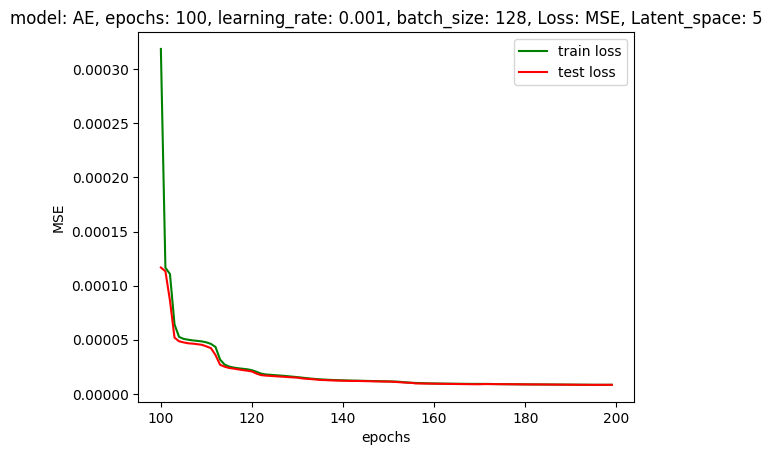

In [5]:
reduce_model.plot_loss()

In [6]:
main_reduced = reduce_model.transform(dataset)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

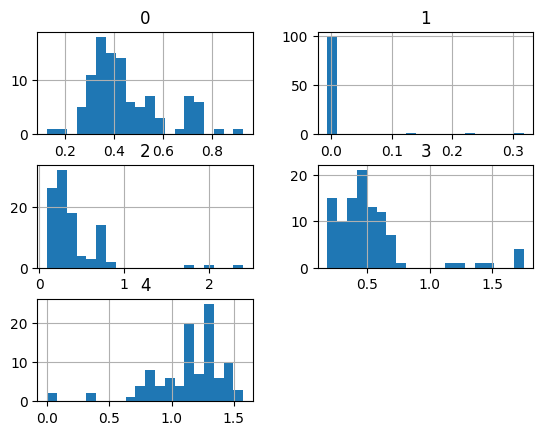

In [7]:
pd.DataFrame(main_reduced).hist(bins=20)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

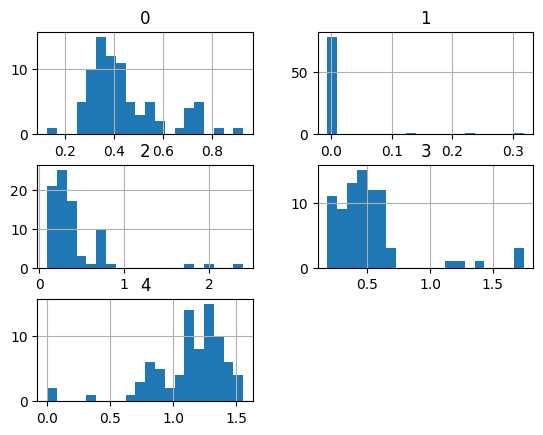

In [21]:
pd.DataFrame(X_train).hist(bins=20)

In [24]:
c_model = ClassifierModel()

In [25]:
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train))

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 77/9223372036854775807 [00:10<339322956863669:41:20,  7.55trial/s, best loss: -0.5897435897435896]
evaluate LGM
  0%|          | 343/9223372036854775807 [00:09<74674249350533:52:32, 34.31trial/s, best loss: -0.4074074074074074] 
evaluate XGB
  0%|          | 207/9223372036854775807 [00:10<124380098722840:57:36, 20.60trial/s, best loss: -0.5428571428571429]
evaluate RF
  0%|          | 84/9223372036854775807 [00:10<307551531141381:20:00,  8.33trial/s, best loss: -0.6666666666666666]
evaluate AdaBoost
  0%|          | 69/9223372036854775807 [00:10<376886151688242:54:56,  6.80trial/s, best loss: -0.7681159420289854]


In [27]:
res

{'CatBoost': {'depth': 8,
  'l2_leaf_reg': 8.395051173930081,
  'learning_rate': 0.00014193746214486564,
  'n_estimators': 98,
  'score': 0.8333333333333333,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 45, '1.0': 20}}},
 'LGM': {'learning_rate': 0.0001419193981856837,
  'max_depth': 9,
  'n_estimators': 48,
  'reg_lambda': 1.5728954467723297,
  'score': 0.41379310344827586,
  'balance': {'test': {'0.0': 12, '1.0': 5}, 'train': {'0.0': 44, '1.0': 20}}},
 'XGB': {'learning_rate': 0.00013548943848579778,
  'max_depth': 44,
  'n_estimators': 50,
  'reg_lambda': 1.4479365377448044,
  'score': 0.7681159420289854,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 45, '1.0': 20}}},
 'RF': {'max_depth': 33,
  'n_estimators': 72,
  'score': 0.7922077922077921,
  'balance': {'test': {'0.0': 11, '1.0': 5}, 'train': {'0.0': 45, '1.0': 20}}},
 'AdaBoost': {'learning_rate': 0.0042827917741860635,
  'max_depth': 2,
  'n_estimators': 85,
  'score': 0.8545454545454546,
  'b

In [29]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in ("balance", "score")} for name in res})

In [30]:
c_model.fit(X_train, y_train)

In [31]:
for name in c_model.models:
    print(f"report for {name}")
    print(metrics.classification_report(y_test, c_model.models[name].predict(X_test)))

report for CatBoost
              precision    recall  f1-score   support

         0.0       0.41      0.78      0.54         9
         1.0       0.50      0.17      0.25        12

    accuracy                           0.43        21
   macro avg       0.46      0.47      0.39        21
weighted avg       0.46      0.43      0.37        21

report for LGM
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60         9
         1.0       0.00      0.00      0.00        12

    accuracy                           0.43        21
   macro avg       0.21      0.50      0.30        21
weighted avg       0.18      0.43      0.26        21

report for XGB
              precision    recall  f1-score   support

         0.0       0.50      0.89      0.64         9
         1.0       0.80      0.33      0.47        12

    accuracy                           0.57        21
   macro avg       0.65      0.61      0.56        21
weighted avg       0.67 

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344